# 11. Simple CNN

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.utils as utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.utils.data as Data

import numpy as np
import os

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## 11.1 Prepare Custom Data

In [3]:
img_dir = "./data/jamo"
img_data = dsets.ImageFolder(img_dir, transforms.Compose([
            transforms.Grayscale(),
            transforms.ToTensor(),
            ]))

#https://pytorch.org/docs/stable/torchvision/transforms.html

print(img_data.classes)
print(img_data.class_to_idx)

['ㄱ', 'ㄲ', 'ㄴ', 'ㄷ', 'ㄸ', 'ㄹ', 'ㅁ', 'ㅂ', 'ㅃ', 'ㅅ', 'ㅆ', 'ㅇ', 'ㅈ', 'ㅉ', 'ㅊ', 'ㅋ', 'ㅌ', 'ㅍ', 'ㅎ', 'ㅏ', 'ㅐ', 'ㅑ', 'ㅒ', 'ㅓ', 'ㅔ', 'ㅕ', 'ㅖ', 'ㅗ', 'ㅘ', 'ㅙ', 'ㅛ', 'ㅜ', 'ㅝ', 'ㅞ', 'ㅟ', 'ㅠ', 'ㅡ', 'ㅢ', 'ㅣ']
{'ㄱ': 0, 'ㄲ': 1, 'ㄴ': 2, 'ㄷ': 3, 'ㄸ': 4, 'ㄹ': 5, 'ㅁ': 6, 'ㅂ': 7, 'ㅃ': 8, 'ㅅ': 9, 'ㅆ': 10, 'ㅇ': 11, 'ㅈ': 12, 'ㅉ': 13, 'ㅊ': 14, 'ㅋ': 15, 'ㅌ': 16, 'ㅍ': 17, 'ㅎ': 18, 'ㅏ': 19, 'ㅐ': 20, 'ㅑ': 21, 'ㅒ': 22, 'ㅓ': 23, 'ㅔ': 24, 'ㅕ': 25, 'ㅖ': 26, 'ㅗ': 27, 'ㅘ': 28, 'ㅙ': 29, 'ㅛ': 30, 'ㅜ': 31, 'ㅝ': 32, 'ㅞ': 33, 'ㅟ': 34, 'ㅠ': 35, 'ㅡ': 36, 'ㅢ': 37, 'ㅣ': 38}


In [4]:
batch_size = 100

In [5]:
def train_test_split(data, train_ratio, batch_size, stratify) :
    
    length = len(data)
    
    cut = int(len(data)*train_ratio)
    train_indices = np.random.shuffle(np.random.permutation(np.arange(length))[:cut])
    test_indices = np.random.shuffle(np.random.permutation(np.arange(length))[cut:])
        
    if stratify :
        
        count = [0]*len(img_data.classes)
        for _, label in img_data :
            count[label] += 1

        weight = []    
        for i, (_, label) in enumerate(img_data) :
            weight.append(1/ count[label])
        weight = np.array(weight)
        
        train_indices = np.random.choice(length, cut, p=weight/sum(weight), replace=False)
        test_indices = np.array(list(set(range(length)) - set(train_indices)))
        
    train_loader = Data.DataLoader(data, batch_size=batch_size, shuffle=False, sampler = torch.utils.data.SubsetRandomSampler(train_indices), drop_last = True)
    test_loader = Data.DataLoader(data, batch_size=batch_size, shuffle=False, sampler = torch.utils.data.SubsetRandomSampler(test_indices), drop_last = True)

    return train_loader, test_loader, len(train_indices), len(test_indices)

In [6]:
train_loader, test_loader, train_num, test_num = train_test_split(img_data, 0.8, batch_size, True)

In [7]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

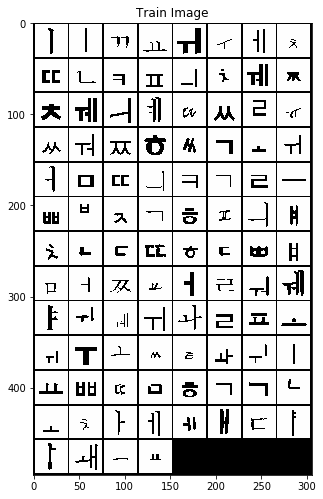

In [8]:
images, labels = iter(train_loader).next()
imshow(torchvision.utils.make_grid(images, normalize=True), "Train Image")

In [9]:
images.shape, labels[0:5]

(torch.Size([100, 1, 36, 36]), tensor([38, 38,  1, 30, 34]))

## 11.2 Define Model

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv_layer = nn.Sequential(
            nn.Conv2d(1,16,3, padding=1), # 16 * 36 * 36
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Conv2d(16,32,3), # 32 * 34 * 34
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Conv2d(32,64,3), # 64 * 32 * 32
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool2d(2,2), # 32 * 16 * 16
            
            nn.Conv2d(64,128,3), # 128 * 14 * 14
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool2d(2,2), # 128 * 7 * 7
        )
        
        self.fc_layer = nn.Sequential(
            nn.Linear(128*7*7, 39)
        ) 
        
    def forward(self,x):
        out = self.conv_layer(x)
        out = out.view(batch_size,-1)
        out = self.fc_layer(out)

        return out

In [11]:
model = CNN().cuda()
model

CNN(
  (conv_layer): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Dropout(p=0.2)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): Dropout(p=0.2)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): Dropout(p=0.2)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (11): ReLU()
    (12): Dropout(p=0.2)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layer): Sequential(
    (0): Linear(in_features=6272, out_features=39, bias=True)
  )
)

In [12]:
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

## 11.3 Train Model

In [13]:
num_epochs = 500

In [17]:
for epoch in range(num_epochs):

    for i, (batch_images, batch_labels) in enumerate(train_loader):

        X = batch_images.cuda()
        Y = batch_labels.cuda()

        pre = model(X)
        cost = loss(pre, Y)

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print('Epoch [%d/%d], lter [%d/%d], Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, train_num//batch_size, cost.item()))

Epoch [1/500], lter [100/224], Loss: 0.0061
Epoch [1/500], lter [200/224], Loss: 0.0041
Epoch [2/500], lter [100/224], Loss: 0.0019
Epoch [2/500], lter [200/224], Loss: 0.0029
Epoch [3/500], lter [100/224], Loss: 0.0023
Epoch [3/500], lter [200/224], Loss: 0.0015
Epoch [4/500], lter [100/224], Loss: 0.0026
Epoch [4/500], lter [200/224], Loss: 0.0036
Epoch [5/500], lter [100/224], Loss: 0.0084
Epoch [5/500], lter [200/224], Loss: 0.0028
Epoch [6/500], lter [100/224], Loss: 0.0022
Epoch [6/500], lter [200/224], Loss: 0.0011
Epoch [7/500], lter [100/224], Loss: 0.0024
Epoch [7/500], lter [200/224], Loss: 0.0023
Epoch [8/500], lter [100/224], Loss: 0.0042
Epoch [8/500], lter [200/224], Loss: 0.0016
Epoch [9/500], lter [100/224], Loss: 0.0022
Epoch [9/500], lter [200/224], Loss: 0.0012
Epoch [10/500], lter [100/224], Loss: 0.0031
Epoch [10/500], lter [200/224], Loss: 0.0008
Epoch [11/500], lter [100/224], Loss: 0.0018
Epoch [11/500], lter [200/224], Loss: 0.0022
Epoch [12/500], lter [100/22

Epoch [107/500], lter [200/224], Loss: 0.0006
Epoch [108/500], lter [100/224], Loss: 0.0004
Epoch [108/500], lter [200/224], Loss: 0.0008
Epoch [109/500], lter [100/224], Loss: 0.0007
Epoch [109/500], lter [200/224], Loss: 0.0007
Epoch [110/500], lter [100/224], Loss: 0.0013
Epoch [110/500], lter [200/224], Loss: 0.0007
Epoch [111/500], lter [100/224], Loss: 0.0007
Epoch [111/500], lter [200/224], Loss: 0.0002
Epoch [112/500], lter [100/224], Loss: 0.0003
Epoch [112/500], lter [200/224], Loss: 0.0008
Epoch [113/500], lter [100/224], Loss: 0.0019
Epoch [113/500], lter [200/224], Loss: 0.0010
Epoch [114/500], lter [100/224], Loss: 0.0005
Epoch [114/500], lter [200/224], Loss: 0.0008
Epoch [115/500], lter [100/224], Loss: 0.0010
Epoch [115/500], lter [200/224], Loss: 0.0006
Epoch [116/500], lter [100/224], Loss: 0.0004
Epoch [116/500], lter [200/224], Loss: 0.0005
Epoch [117/500], lter [100/224], Loss: 0.0004
Epoch [117/500], lter [200/224], Loss: 0.0003
Epoch [118/500], lter [100/224], L

Epoch [197/500], lter [100/224], Loss: 0.0004
Epoch [197/500], lter [200/224], Loss: 0.0003
Epoch [198/500], lter [100/224], Loss: 0.0005
Epoch [198/500], lter [200/224], Loss: 0.0003
Epoch [199/500], lter [100/224], Loss: 0.0004
Epoch [199/500], lter [200/224], Loss: 0.0002
Epoch [200/500], lter [100/224], Loss: 0.0007
Epoch [200/500], lter [200/224], Loss: 0.0009
Epoch [201/500], lter [100/224], Loss: 0.0003
Epoch [201/500], lter [200/224], Loss: 0.0009
Epoch [202/500], lter [100/224], Loss: 0.0002
Epoch [202/500], lter [200/224], Loss: 0.0003
Epoch [203/500], lter [100/224], Loss: 0.0005
Epoch [203/500], lter [200/224], Loss: 0.0007
Epoch [204/500], lter [100/224], Loss: 0.0005
Epoch [204/500], lter [200/224], Loss: 0.0003
Epoch [205/500], lter [100/224], Loss: 0.0003
Epoch [205/500], lter [200/224], Loss: 0.0009
Epoch [206/500], lter [100/224], Loss: 0.0003
Epoch [206/500], lter [200/224], Loss: 0.0008
Epoch [207/500], lter [100/224], Loss: 0.0004
Epoch [207/500], lter [200/224], L

Epoch [302/500], lter [100/224], Loss: 0.0007
Epoch [302/500], lter [200/224], Loss: 0.0002
Epoch [303/500], lter [100/224], Loss: 0.0005
Epoch [303/500], lter [200/224], Loss: 0.0004
Epoch [304/500], lter [100/224], Loss: 0.0006
Epoch [304/500], lter [200/224], Loss: 0.0003
Epoch [305/500], lter [100/224], Loss: 0.0004
Epoch [305/500], lter [200/224], Loss: 0.0011
Epoch [306/500], lter [100/224], Loss: 0.0003
Epoch [306/500], lter [200/224], Loss: 0.0003
Epoch [307/500], lter [100/224], Loss: 0.0010
Epoch [307/500], lter [200/224], Loss: 0.0003
Epoch [308/500], lter [100/224], Loss: 0.0001
Epoch [308/500], lter [200/224], Loss: 0.0002
Epoch [309/500], lter [100/224], Loss: 0.0008
Epoch [309/500], lter [200/224], Loss: 0.0004
Epoch [310/500], lter [100/224], Loss: 0.0004
Epoch [310/500], lter [200/224], Loss: 0.0004
Epoch [311/500], lter [100/224], Loss: 0.0005
Epoch [311/500], lter [200/224], Loss: 0.0015
Epoch [312/500], lter [100/224], Loss: 0.0004
Epoch [312/500], lter [200/224], L

Epoch [391/500], lter [200/224], Loss: 0.0000
Epoch [392/500], lter [100/224], Loss: 0.0002
Epoch [392/500], lter [200/224], Loss: 0.0001
Epoch [393/500], lter [100/224], Loss: 0.0001
Epoch [393/500], lter [200/224], Loss: 0.0006
Epoch [394/500], lter [100/224], Loss: 0.0002
Epoch [394/500], lter [200/224], Loss: 0.0001
Epoch [395/500], lter [100/224], Loss: 0.0011
Epoch [395/500], lter [200/224], Loss: 0.0001
Epoch [396/500], lter [100/224], Loss: 0.0003
Epoch [396/500], lter [200/224], Loss: 0.0007
Epoch [397/500], lter [100/224], Loss: 0.0002
Epoch [397/500], lter [200/224], Loss: 0.0001
Epoch [398/500], lter [100/224], Loss: 0.0001
Epoch [398/500], lter [200/224], Loss: 0.0002
Epoch [399/500], lter [100/224], Loss: 0.0004
Epoch [399/500], lter [200/224], Loss: 0.0003
Epoch [400/500], lter [100/224], Loss: 0.0003
Epoch [400/500], lter [200/224], Loss: 0.0003
Epoch [401/500], lter [100/224], Loss: 0.0003
Epoch [401/500], lter [200/224], Loss: 0.0007
Epoch [402/500], lter [100/224], L

Epoch [496/500], lter [100/224], Loss: 0.0001
Epoch [496/500], lter [200/224], Loss: 0.0003
Epoch [497/500], lter [100/224], Loss: 0.0004
Epoch [497/500], lter [200/224], Loss: 0.0001
Epoch [498/500], lter [100/224], Loss: 0.0006
Epoch [498/500], lter [200/224], Loss: 0.0005
Epoch [499/500], lter [100/224], Loss: 0.0006
Epoch [499/500], lter [200/224], Loss: 0.0001
Epoch [500/500], lter [100/224], Loss: 0.0002
Epoch [500/500], lter [200/224], Loss: 0.0004


## 11.4 Test Model

In [19]:
model.eval()

correct = 0
total = 0

for images, labels in test_loader:
    
    images = images.cuda()
    outputs = model(images)
    
    _, predicted = torch.max(outputs.data, 1)
    
    total += labels.size(0)
    correct += (predicted == labels.cuda()).sum()
    
print('Accuracy of test images: %f %%' % (100 * float(correct) / total))

Accuracy of test images: 96.464286 %
